### Here we use the codes in src/generate_adversarial.py to generate final report

In [1]:
# Copyright 2017 Ruifan Yu.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================
"""Load previous CNN model for MNIST and generate adversarial image

For the details of adversarial image, please refer to Ian J. Goodfellow et al.
    Explaining and Harnessing Adversarial Examples (https://arxiv.org/abs/1412.6572)
"""
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import tensorflow as tf

import seaborn as sns

import numpy as np
import matplotlib.pyplot as plt

### Just import the code

In [2]:
def build_graph():
  """build the same graph as previous dumped model

  Args:
    None

  Returns:
    sess          : tf.InteractiveSession()
    x             : tf.placeholder()
    y_            : tf.placeholder()
    y_pred,       : tf.Variable()
    keep_prob,    : tf.placeholder()
    cross_entropy : tf.Variable()

  Example:
    >>> build_graph()
  """
  x = tf.placeholder(tf.float32, shape=[None, 784])
  y_ = tf.placeholder(tf.float32, shape=[None, 10])

  def weight_variable(shape):
    """Create a weight variable with appropriate initialization."""
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

  def bias_variable(shape):
    """Create a bias variable with appropriate initialization."""
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)
    
  def conv2d(x, W):
    """simple conv2d layer"""
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

  def max_pool_2x2(x):
    """a simple 2x2 max pool layer"""
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')
  
  # First conv layer with a pool layer
  W_conv1 = weight_variable([5, 5, 1, 32])
  b_conv1 = bias_variable([32])

  x_image = tf.reshape(x, [-1,28,28,1])
  h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
  h_pool1 = max_pool_2x2(h_conv1)

  # Second conv layer with a pool layer
  W_conv2 = weight_variable([5, 5, 32, 64])
  b_conv2 = bias_variable([64])

  h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
  h_pool2 = max_pool_2x2(h_conv2)

  # First Full-connect layer
  W_fc1 = weight_variable([7 * 7 * 64, 1024])
  b_fc1 = bias_variable([1024])

  h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64])
  h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

  keep_prob = tf.placeholder(tf.float32)
  h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

  # Second Full-connect layer
  W_fc2 = weight_variable([1024, 10])
  b_fc2 = bias_variable([10])

  # output layer
  y_conv = tf.matmul(h_fc1_drop, W_fc2) + b_fc2
  y_pred = tf.nn.softmax(y_conv)
  cross_entropy = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y_conv))
  
  sess = tf.InteractiveSession()
  return sess, x, y_, y_pred, keep_prob, cross_entropy

def generate_adversarial(model_path, img_list, target_class, eta=0.001, 
        threshold=0.99, save_path=None, file_name='adversarial', verbose=0):
  """generate adversarial images, note that gradient and some parts of 
    graph are needed during iterations, hence I decide not to pack some codes 
    into helper function

  Args:
    tensor_in: `Tensor`, input tensor.
    other_tensor_in: `Tensor`, same shape as `tensor_in`, other input tensor.
    my_param: `float`, coefficient for `tensor_in`.
    other_param: `float`, coefficient for `other_tensor_in`.
    output_collections: `tuple` of `string`s, name of the collection to
                        collect result of this op.
    name: `string`, name of the operation.

    model_path: `string`, the path to previous model
    img_list: `string`, the img list that need to generate adversarial images
    target_class: `int`, the wanted label
    eta: `float`, learning rate (or step size), default: 0.001
    threshold: `float`, the confidence we want to fool, default: 0.99 (99%)
    save_path: `string`, the path to img/ folder
    file_name: `string`, the name for saving file, default:'adversarial'
    verbose: `int`, verbose=0, omit the training graphs, default: 0

  Returns:
    `np.array`: the final adversarial image for each img in img_list

  Example:
    >>> generate_adversarial(model_path='../model/MNIST.ckpt', 
                img_list=img_list, target_class=6, eta=0.01, threshold=0.99, 
                save_path='../img/', file_name='adversarial', verbose=1)
    np.ndarray(...)
  """
  sess, x, y_, y_pred, keep_prob, cross_entropy = build_graph()

  sess.run(tf.global_variables_initializer())
  tf.train.Saver().restore(sess, model_path)
  print('load model from', model_path)
  
  prediction=tf.argmax(y_pred,1)
  probabilities=y_pred

  img_gradient = tf.gradients(cross_entropy, x)[0]

  adversarial_img_list = list()

  # generate versus figure
  sns.set_style('white')
  versus_fig = plt.figure(figsize=(9, 40))

  for img_index in range(0, img_list.shape[0]):
    adversarial_img = img_list[img_index: img_index+1].copy()
    adversarial_label = np.zeros((1, 10))
    adversarial_label[:, target_class] = 1
    
    confidence = 0
    iter_num = 0
    prob_history = list()
    while confidence < threshold:
      probabilities_val = probabilities.eval(feed_dict=
                        {x: adversarial_img, keep_prob: 1.0}, session=sess)
      confidence = probabilities_val[:, 6]
      prob_history.append(probabilities_val[0])
      
      gradient = img_gradient.eval(
          {x: adversarial_img, y_: adversarial_label, keep_prob: 1.0})
      adversarial_img -= eta * gradient
      iter_num += 1
    print('generate adversarial image after', iter_num, 'iterations')

    # generate versus figure

    ax1 = versus_fig.add_subplot(10, 3, 3*img_index+1)
    ax1.axis('off')
    ax1.imshow(img_list[img_index].reshape([28, 28]), 
              interpolation=None, cmap=plt.cm.gray)
    ax1.title.set_text(
          'Confidence for 2: ' + '{:.4f}'.format(prob_history[0][2]) 
          + '\nConfidence for 6: ' + '{:.4f}'.format(prob_history[0][6]))

    ax2 = versus_fig.add_subplot(10, 3, 3*img_index+2)
    ax2.axis('off')
    ax2.imshow((adversarial_img - img_list[img_index]).reshape([28, 28]),
                interpolation=None, cmap=plt.cm.gray)
    ax2.title.set_text('Delta')

    ax3 = versus_fig.add_subplot(10, 3, 3*img_index+3)
    ax3.axis('off')
    ax3.imshow((adversarial_img).reshape([28, 28]), 
                interpolation=None, cmap=plt.cm.gray)
    ax3.title.set_text(
          'Confidence for 2: ' + '{:.4f}'.format(prob_history[-1][2]) 
          + '\nConfidence for 6: ' + '{:.4f}'.format(prob_history[-1][6]))

    print("Difference Measure:", 
                      np.sum((adversarial_img - img_list[img_index]) ** 2))
    adversarial_img_list.append(adversarial_img)

    if verbose != 0:
      sns.set_style('whitegrid')
      colors_list = sns.color_palette("Paired", 10)
      # generate Iteration figure
      prob_history = np.array(prob_history)

      fig = plt.figure(figsize=(10, 6))
      ax = fig.add_subplot(111)

      for i, record in enumerate(prob_history.T):
          plt.plot(record, color=colors_list[i])

      ax.legend([str(x) for x in range(0, 10)], 
                  loc='center left', bbox_to_anchor=(1.01, 0.5), fontsize=14)
      ax.set_xlabel('Iteration')
      ax.set_ylabel('Prediction Confidence')
      fig.savefig(save_path + file_name + str(img_index) + '_iter.png')

  versus_fig.tight_layout()
  versus_fig.savefig(save_path + file_name + '_versus.png')
  return np.array(adversarial_img_list)

### Here we randomly select 10 images from mnist.test as input

In [3]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('/tmp/tensorflow/mnist/input_data', one_hot=True)

Extracting /tmp/tensorflow/mnist/input_data/train-images-idx3-ubyte.gz
Extracting /tmp/tensorflow/mnist/input_data/train-labels-idx1-ubyte.gz
Extracting /tmp/tensorflow/mnist/input_data/t10k-images-idx3-ubyte.gz
Extracting /tmp/tensorflow/mnist/input_data/t10k-labels-idx1-ubyte.gz


In [4]:
%matplotlib inline

In [5]:
index_mask = np.where(mnist.test.labels[:, 2])[0]
subset_mask = np.random.choice(index_mask, 10)
origin_images = mnist.test.images[subset_mask]
origin_labels = mnist.test.labels[subset_mask]

### Call the function to get result

load model from ../model/MNIST.ckpt
generate adversarial image after 153 iterations
Difference Measure: 8.4642
generate adversarial image after 260 iterations
Difference Measure: 9.08797
generate adversarial image after 314 iterations
Difference Measure: 7.28537
generate adversarial image after 165 iterations
Difference Measure: 6.02879
generate adversarial image after 323 iterations
Difference Measure: 13.1433
generate adversarial image after 315 iterations
Difference Measure: 10.909
generate adversarial image after 494 iterations
Difference Measure: 5.20075
generate adversarial image after 437 iterations
Difference Measure: 10.4726
generate adversarial image after 337 iterations
Difference Measure: 8.53919
generate adversarial image after 787 iterations
Difference Measure: 11.0631


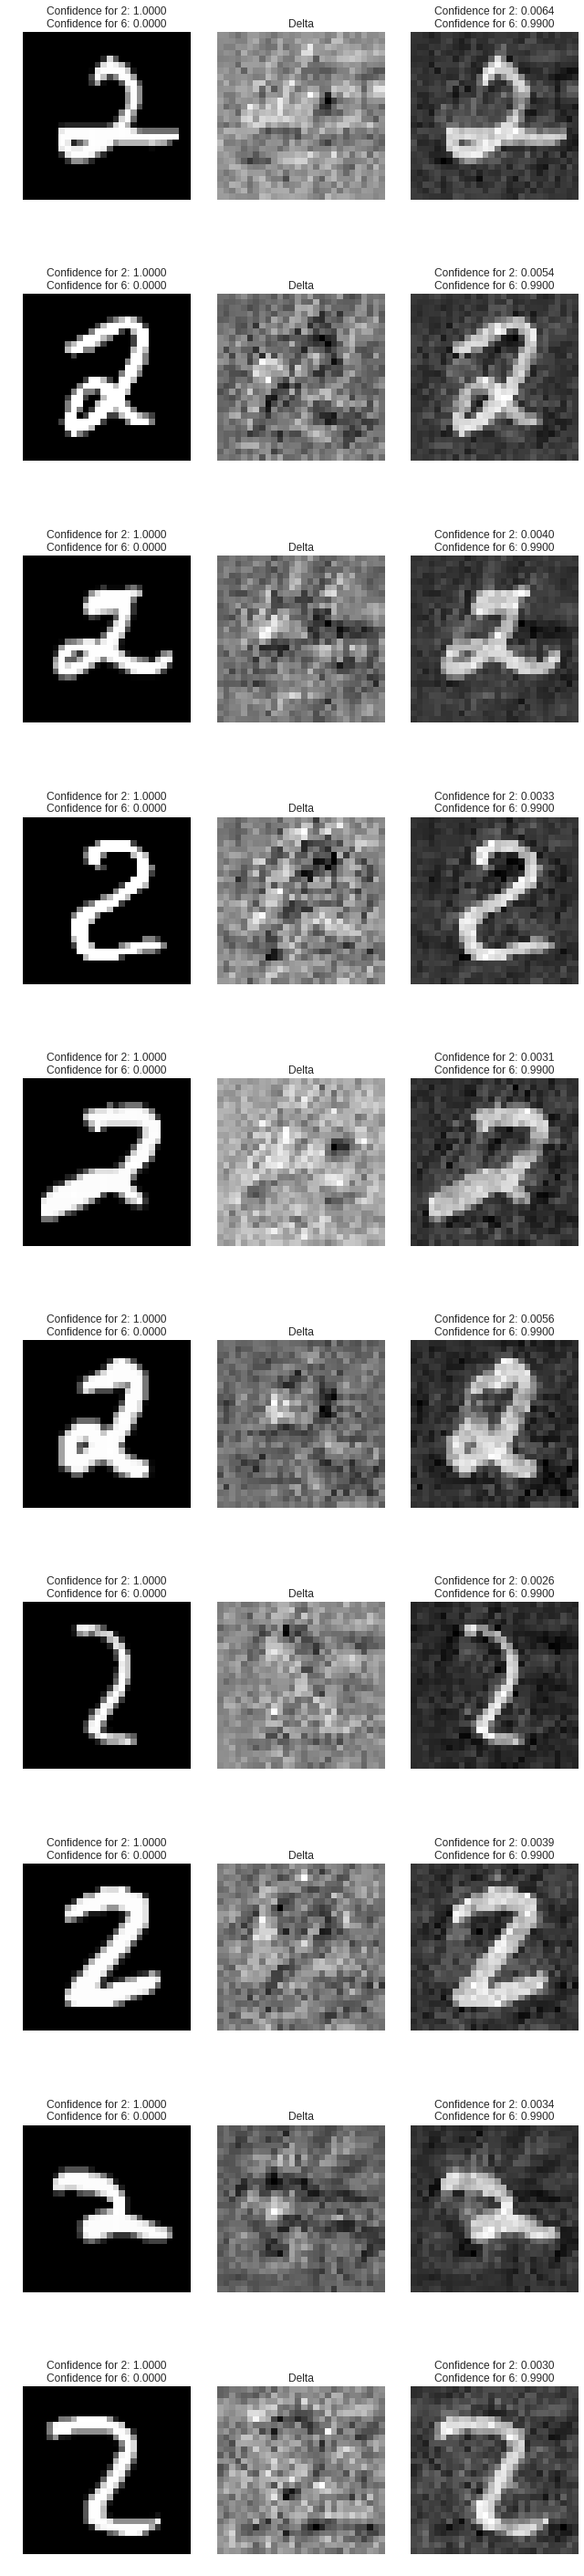

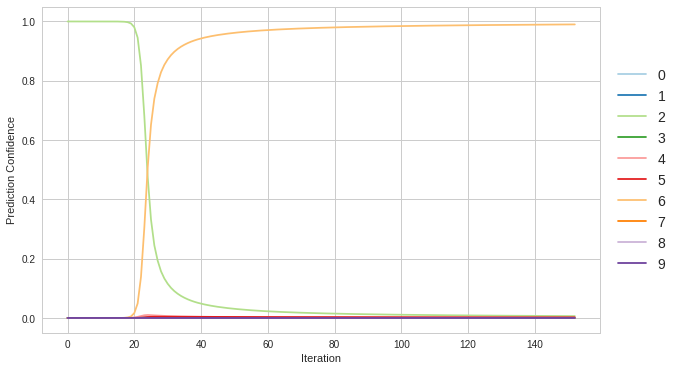

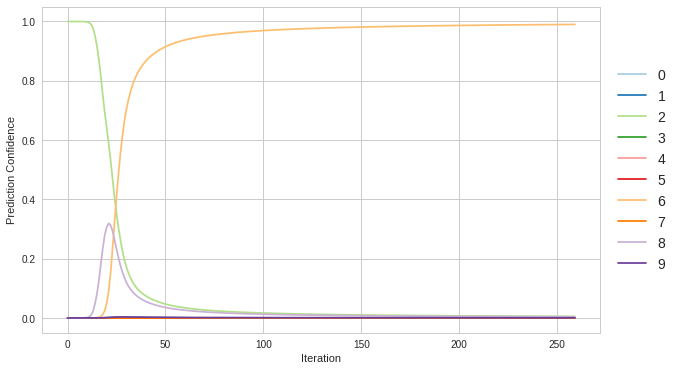

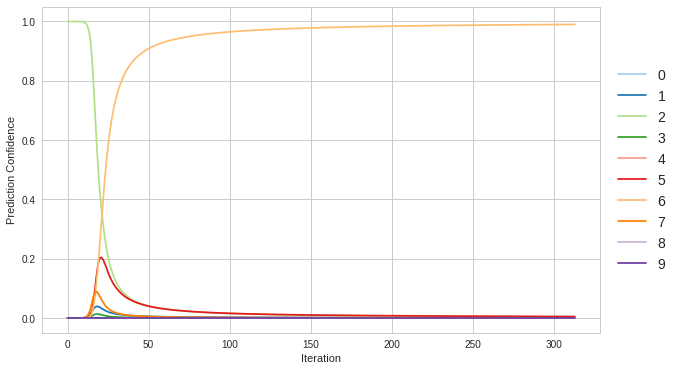

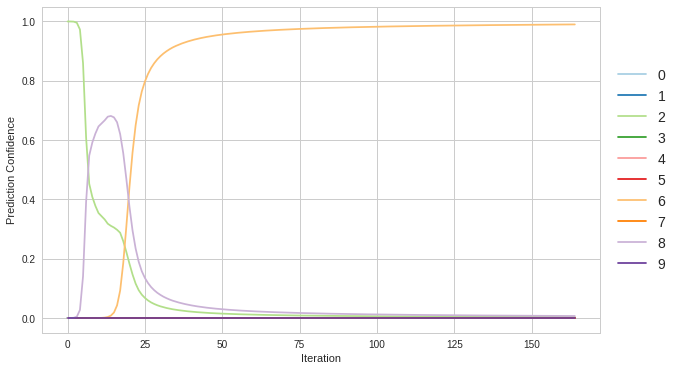

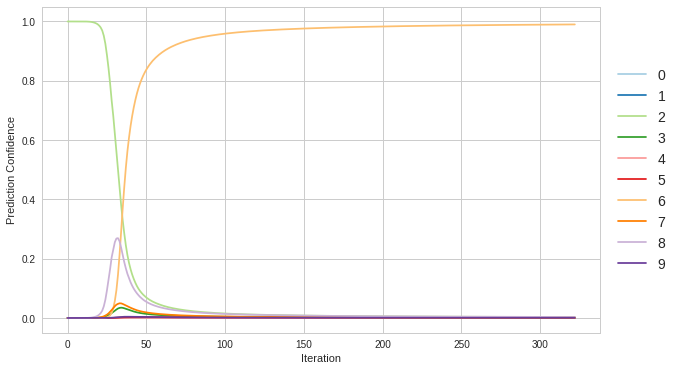

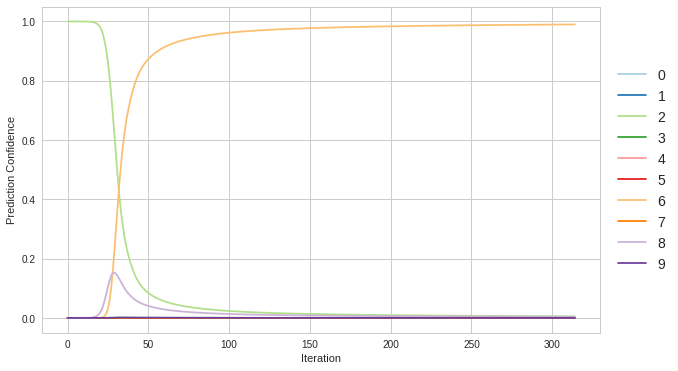

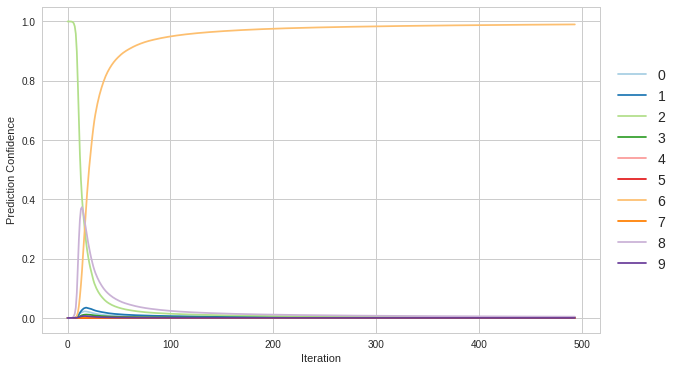

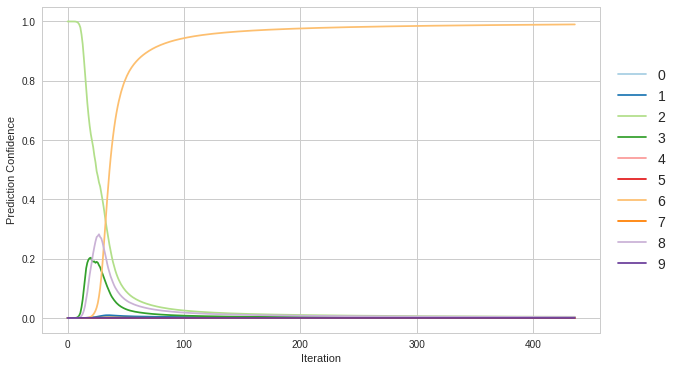

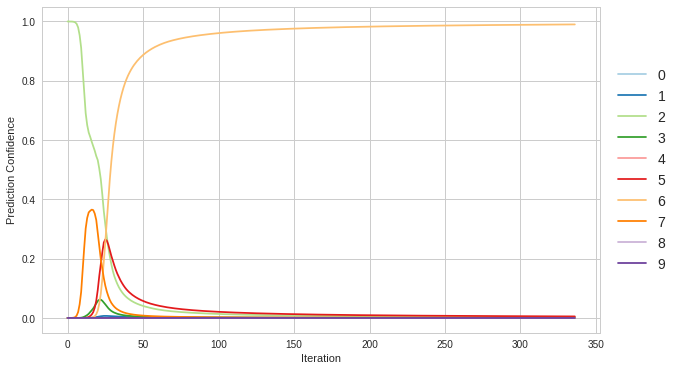

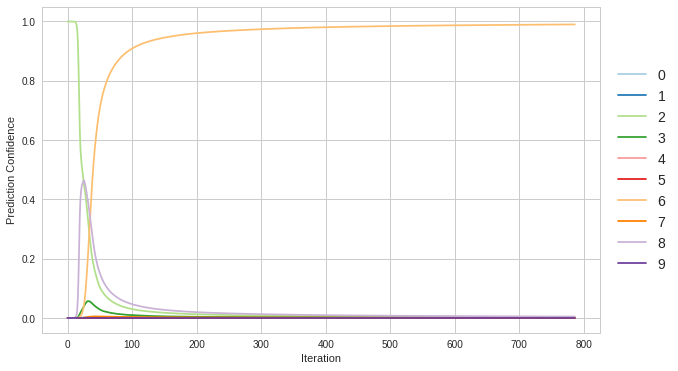

In [6]:
ad_img = generate_adversarial(model_path='../model/MNIST.ckpt', img_list=origin_images, target_class=6, eta=0.01, threshold=0.99, 
                        save_path='../img/', file_name='adversarial', verbose=1)